https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html?highlight=group

https://stackoverflow.com/questions/36392735/how-to-combine-multiple-rows-into-a-single-row-with-pandas

In [1]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import freeman

1. Carregando os datasets

In [2]:
atbats_csv = pd.read_csv('atbats.csv')
games_csv = pd.read_csv('games.csv')
player_names_csv = pd.read_csv('player_names.csv')
player_names_csv['name'] = player_names_csv

In [14]:
player_names_csv[player_names_csv.id == 452657]

,id,first_name,last_name
0,452657,Jon,Lester


2. Combinacao dos datasets de jogos e rebatedores em relacao ao identificador do jogo

In [3]:
merged = pd.merge(games_csv, atbats_csv, how="inner", on=["g_id"])
games = merged.groupby(by=['g_id'])

3. Criando dicionario para facilitar o manejamento de informacao por jogo disputado.

In [5]:
games_teams = {}
for gameId in games.groups:
    game = games.get_group(gameId)
    games_teams[gameId] = {
        "home_team": {
            "name": game.home_team.values[0],
            "batters": [],
            "pitchers": []
        },
        "away_team": {
            "name": game.away_team.values[0],
            "batters": [],
            "pitchers": []
        }
    }

    batters = game.groupby(by="batter_id")
    for batterId in batters.groups:
        batter = batters.get_group(batterId)
        if batter.top.max() != True:
            games_teams[gameId]["home_team"]["batters"].append(batterId)
        else:
            games_teams[gameId]["away_team"]["batters"].append(batterId)

    pitchers = game.groupby(by="pitcher_id")
    for pitcherId in pitchers.groups:
        pitcher = pitchers.get_group(pitcherId)
        if pitcher.top.max() == True:
            games_teams[gameId]["home_team"]["pitchers"].append(pitcherId)
        else:
            games_teams[gameId]["away_team"]["pitchers"].append(pitcherId)

In [6]:
game_data = {}
for gameId in games.groups:
    game = games.get_group(gameId)
    game_data[gameId] = {
        game.home_team.values[0]: [],
        game.away_team.values[0]: []
    }

    batters = game.groupby(by="batter_id")
    for batterId in batters.groups:
        batter = batters.get_group(batterId)
        if batter.top.max() != True:
            game_data[gameId][game.home_team.values[0]].append(batterId)
        else:
            game_data[gameId][game.away_team.values[0]].append(batterId)

    pitchers = game.groupby(by="pitcher_id")
    for pitcherId in pitchers.groups:
        pitcher = pitchers.get_group(pitcherId)
        if pitcher.top.max() == True:
            game_data[gameId][game.home_team.values[0]].append(pitcherId)
        else:
            game_data[gameId][game.away_team.values[0]].append(pitcherId)

In [7]:
player_ids = player_names_csv["id"].values #65

In [8]:

for game, teams in game_data.items():
    for team, players in teams.items():
        game_data[game][team] = list(set(players))
connections = {}
for game in game_data.values():
    for team, players in game.items():
        for index in range(len(players) - 2):
            player = players[index]
            player_connections = connections.get(player, None)
            if not player_connections:
                connections[player] = set()
            for i in range(index + 1, len(players)):
                partner = players[i]
                connection = connections.get(partner, None)
                if not connection or player not in connection:
                    connections[player].add(partner)
for player in player_ids:
    if player not in connections:
        connections[player] = []

        

4. Criacao da rede no arquivo .gml

In [9]:
gml = 'graph [\n\tdirected 0\n'
for player in connections.keys():
    gml += f"\n\tnode [\n\t\tid {player}\n\t]"
gml += '\n'
for player, player_connections in connections.items():
    for connection in player_connections:
        gml += f'\n\tedge [\n\t\tsource {player}\n\t\ttarget {connection}\n\t]'
gml += '\n]'
with open('network.gml', 'w') as f:
    f.write(gml)

5. Cálculo das estatísticas dos Pitchers

Extraindo dados de WHIP

In [27]:
pitcher_data = {}
for index, row in atbats_csv.iterrows():
    pitcher_id = row['pitcher_id']
    pitcher = pitcher_data.get(pitcher_id, None)
    if not pitcher:
        pitcher_data[pitcher_id] = {
            'last_name': player_names_csv.loc[player_names_csv.id == pitcher_id].last_name.values[0],
            'first_name': player_names_csv.loc[player_names_csv.id == pitcher_id].first_name.values[0],
            'walks': 0,
            'hits': 0,
            'at-bats': 0,
            'IP': {
                '2015': 0,
                '2016': 0,
                '2017': 0,
                '2018': 0
            },
            'ER': {
                '2015': 0,
                '2016': 0,
                '2017': 0,
                '2018': 0
            }
        }
    pitcher_data[pitcher_id]['at-bats'] += 1
    year = str(row['ab_id'])[:4]
    at_bat_result = row['event']
    if at_bat_result in ['Walk', 'Intent Walk', 'Hit By Pitch']:
        pitcher_data[pitcher_id]['walks'] += 1
    elif at_bat_result in ['Double', 'Single', 'Triple', 'Home Run']:
        pitcher_data[pitcher_id]['hits'] += 1
    elif at_bat_result in ['Groundout', 'Strikeout', 'Runner Out', 'Flyout', 'Forceout', 'Pop out', 'Lineout', 'Sac Bunt', 'Bunt Groundout', 'Sac Fly', 'Fielders Choice Out', 'Bunt Pop Out', 'Bunt Lineout']:
        pitcher_data[pitcher_id]['IP'][year] += 1/3
    elif at_bat_result in ['Double Play', 'Grounded Into DP', 'Strikeout - DP', 'Sac Fly DP', 'Sacrifice Bunt DP']:
        pitcher_data[pitcher_id]['IP'][year] += 2/3
    elif at_bat_result == 'Triple Play':
        pitcher_data[pitcher_id]['IP'][year] += 1
    

In [28]:
for pitcher in pitcher_data.keys():
    try:
        pitcher_data[pitcher]['WHIP'] = (pitcher_data[pitcher]['walks'] + pitcher_data[pitcher]['hits'])/sum([ip for ip in pitcher_data[pitcher]['IP'].values()])
    except:
        pitcher_data[pitcher]['WHIP'] = None

Extraindo ERA

In [29]:
pitcher_data[457435]

{'last_name': 'Coke',
 'first_name': 'Phil',
 'walks': 13,
 'hits': 25,
 'at-bats': 101,
 'IP': {'2015': 12.333333333333337,
  '2016': 9.666666666666668,
  '2017': 0,
  '2018': 0},
 'ER': {'2015': 0, '2016': 0, '2017': 0, '2018': 0},
 'WHIP': 1.7272727272727266}

In [30]:
for i in range(2015, 2019):
    error = []
    stats = pd.read_csv(f'stats{i}.csv')
    stats['first_name'] = stats.first_name.str.strip()
    for pitcher in pitcher_data.keys():
        try:
            if pitcher_data[pitcher]['IP'][str(i)] > 0:
                pitcher_data[pitcher]['ER'][str(i)] = stats.loc[(stats.first_name == pitcher_data[pitcher]['first_name']) & (stats.last_name == pitcher_data[pitcher]['last_name'])]['p_earned_run'].values[0]
            else:
                pitcher_data[pitcher]['ER'][str(i)] = 0
        except Exception as e:
            print(e)
            error.append(pitcher)
            pitcher_data[pitcher]['ER'][str(i)] = 0
        # if pitcher_data[pitcher]['IP'][str(i)] > 0:
        #     pitcher_data[pitcher]['ERA'][str(i)] = df.loc[df.player_id == pitcher][f'era{i}'].values[0]
        # else:
        #     pitcher_data[pitcher]['ERA'][str(i)] = 0
    print(error)
    print(len(error))
    print('#############')


index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

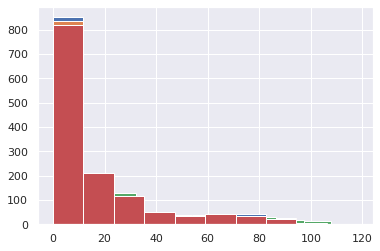

In [32]:
import matplotlib.pyplot as plt
plt.hist([p['ER']['2015'] for p in pitcher_data.values()]);
plt.hist([p['ER']['2016'] for p in pitcher_data.values()]);
plt.hist([p['ER']['2017'] for p in pitcher_data.values()]);
plt.hist([p['ER']['2018'] for p in pitcher_data.values()]);

In [40]:
for pitcher in pitcher_data.keys():
        try:
                pitcher_data[pitcher]['cERA'] = 9*sum([er for er in pitcher_data[pitcher]['ER'].values()])/sum([ip for ip in pitcher_data[pitcher]['IP'].values()])
        except:
               pitcher_data[pitcher]['cERA'] = None

In [41]:
data = pd.DataFrame({
    'pitcher_id': [n for n in pitcher_data.keys()],
    'walks': [n['walks'] for n in pitcher_data.values()],
    'hits': [n['hits'] for n in pitcher_data.values()],
    'at-bats': [n['at-bats'] for n in pitcher_data.values()],
    'IP': [sum([ip for ip in n['IP'].values()]) for n in pitcher_data.values()],
    'WHIP': [n['WHIP'] for n in pitcher_data.values()],
    'cERA': [n['cERA'] for n in pitcher_data.values()]
})

In [42]:
data.to_csv('pitcher_data.csv') #138